# Data Load

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset, Subset
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Combine Datasets

In [3]:
def split_data(data, train_ratio = 0.8, valid_ratio = 0.1):
    random.seed = 1773

    # Shuffle indices of data
    total_data_len = len(data)
    indices = list(range(total_data_len))
    random.shuffle(indices)

    # Sizes of the train, test, val
    train_size = int(train_ratio * total_data_len)
    valid_size = int(valid_ratio * total_data_len)
    test_size = total_data_len - train_size - valid_size

    # Chosing indices for splitting
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]
    
    # Choosing subsets according to indices
    #Therefore we can split data randomly
    train_dataset = Subset(data, train_indices)
    valid_dataset = Subset(data, valid_indices)
    test_dataset = Subset(data, test_indices)
    
    return train_dataset, valid_dataset, test_dataset

In [4]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, transform = transform_image, mask_prob = 0.2, patch_size = 16):
        self.dataset = dataset
        self.transform = transform
        self.mask_prob = mask_prob  # Probability of the masking an image
        self.patch_size = patch_size       
    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        image = self.dataset[index][0]

        image = self.transform(image)

        masked_image, mask = self.create_mask(image)

        return image, masked_image, mask

        
    def create_mask(self, image):
        masked_image = image.clone()
        random.seed = 1773
        _, height, width = image.shape

        # Calculate the number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        

        # An array shape like image
        # True for positions of the mask
        # False for rest of the array
        mask = torch.zeros((num_patches_h * num_patches_w), dtype=torch.bool)
        
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if random.random() < self.mask_prob:
                    x_min, x_max = i * self.patch_size,  (i+1) * self.patch_size
                    y_min, y_max = j * self.patch_size,  (j+1) * self.patch_size

                    masked_image[:, x_min:x_max, y_min:y_max] = 0
                    mask[i * num_patches_w + j] = True
                    
        return masked_image, mask
    


In [6]:
dataset1 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\celeba",
)

dataset2 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\places",
)
random.seed = 1773
custom_data1 = Custom_Dataset(dataset1, transform=transform_image)
custom_data2 = Custom_Dataset(dataset2, transform=transform_image)

combined_dataset = ConcatDataset([custom_data1, custom_data2])


train_dataset, valid_dataset, test_dataset = split_data(combined_dataset)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Example of Mask

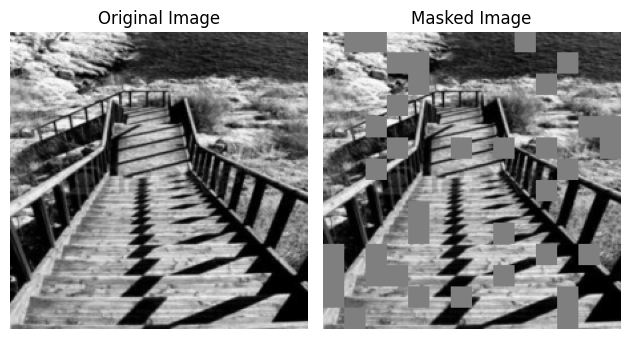

In [7]:
def unnormalize_and_convert(image):
    image = image.permute(1, 2, 0).cpu().detach().numpy()  
    image = (image * 0.5) + 0.5  
    image = np.clip(image, 0, 1)  
    return image

original_image, masked_image, mask = train_dataset[random.randint(0,2000)]  

plt.figure()

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(unnormalize_and_convert(original_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(unnormalize_and_convert(masked_image))
plt.axis('off')

plt.tight_layout()
plt.show()


# Transformer

In [8]:
from transformers import ViTModel
from transformers import ViTConfig
from tqdm import tqdm
from torchvision.models import vgg16
from pytorch_msssim import SSIM
from pytorch_msssim import ssim
import math
from IPython.display import clear_output
import os
import csv





C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class ViT_decoder(nn.Module):
    def __init__(self, pretrained_model_name="google/vit-base-patch16-224-in21k"):
        super(ViT_decoder, self).__init__()
        config = ViTConfig(image_size=224, patch_size=16, hidden_size=768, 
                           num_hidden_layers=4, num_attention_heads=4)

        self.vit = ViTModel.from_pretrained(pretrained_model_name, config= config)
        
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.vit.encoder.parameters():
            param.requires_grad = True
        
    

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.vit.config.hidden_size, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),  # Final layer for RGB
        )

    def forward(self, image, mask):
        output = self.vit(image).last_hidden_state
        output = output[:, 1:, :]
        
        batch_size, seq_len, hidden_dim = output.shape
        patch_size = int(seq_len**0.5)
        
        output = output.permute(0, 2, 1).view(batch_size, hidden_dim, patch_size, patch_size)
        output = self.decoder(output)

        return output

## Plot Sample Image

In [10]:
def plot_sample_image(original_image, masked_image, inpainted_image, expanded_mask, save_path=None, image_name=None):   
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(unnormalize_and_convert(original_image))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(unnormalize_and_convert(masked_image))
    ax[1].set_title("Masked Image")
    ax[1].axis('off')

    inpainted_image = inpainted_image * expanded_mask + masked_image
    ax[2].imshow(unnormalize_and_convert(inpainted_image))
    ax[2].set_title("Inpainted Image")
    ax[2].axis('off')
    
    plt.tight_layout()

    if save_path and image_name is not None:
        os.makedirs(save_path, exist_ok=True)  # Ensure directory exists
        file_path = os.path.join(save_path, image_name)
        plt.savefig(file_path)
        print(f"Saved: {file_path}")
    plt.show()

## Performance Metrics

In [11]:
def psnr(output, target, mask):
    """Compute PSNR (Peak Signal-to-Noise Ratio)"""
    output = output * mask
    target = target * mask
    mse = torch.mean((output - target) ** 2, dim=(1, 2, 3))
    mse = torch.where(mse == 0, torch.tensor(1e-10).to(mse.device), mse)
    psnr_value = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr_value.mean().item()

def pixel_accuracy(output, target, mask):
    output = output * mask
    target = target * mask
    correct = (torch.abs(output - target) < 1).float()
    denominator = mask.sum(dim=(1, 2, 3))
    denominator = torch.where(denominator == 0, torch.tensor(1.0).to(denominator.device), denominator)
    acc_per_image = correct.sum(dim=(1, 2, 3)) / denominator
    return acc_per_image.mean().item()


## Loss Functions

In [12]:
import torch.nn.functional as F
from torchvision.models import vgg11

class LightweightPerceptualLoss(nn.Module):
    def __init__(self):
        super(LightweightPerceptualLoss, self).__init__()
        vgg = vgg11(pretrained=True).features[:8]
        self.feature_extractor = nn.Sequential(*list(vgg))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False 

    def forward(self, output, target):
        output_features = self.feature_extractor(output)
        target_features = self.feature_extractor(target)
        loss = F.mse_loss(output_features, target_features)  # MSE between feature maps
        return loss

In [13]:
class CombinedLoss(nn.Module):
    def __init__(self, perceptual_weight=0.3, ssim_weight=0.7):
        super(CombinedLoss, self).__init__()
        self.perceptual_loss = LightweightPerceptualLoss()
        self.ssim_loss = SSIM(data_range=1, size_average=True, channel=3)
        self.perceptual_weight = perceptual_weight
        self.ssim_weight = ssim_weight

    def forward(self, output, target, expanded_mask):
        masked_output = output * expanded_mask
        masked_target = target * expanded_mask

        ssim_loss = 1 - self.ssim_loss(masked_output, masked_target)
        perceptual_loss = self.perceptual_loss(output, target)
        total_loss = self.ssim_weight * ssim_loss + self.perceptual_weight * perceptual_loss
        return total_loss

## Train Model

In [14]:
def save_checkpoint(epoch, model, optimizer, scaler, best_valid_loss, path="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
        "best_valid_loss": best_valid_loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")



In [19]:
def train_model(model, optimizer, scaler, start_epoch, best_valid_loss, train_loader, valid_loader, num_epochs=1, device="cuda"):
    
    patience = 3
    patience_counter = 0


    model.to(device)
    criterion = CombinedLoss().to(device)


    model.train()

    for epoch in range(start_epoch, start_epoch + num_epochs): 
        train_loss = 0.0
        train_PSNR = 0.0
        train_accuracy = 0.0
        plot_counter = 1
        idx = 0

        for images, masked_images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}, Train"):
            plot_counter -= 1
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)
            
            expanded_mask = masks.view(masks.size(0),14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()
            
            with torch.amp.autocast("cuda"):
                outputs = model(masked_images, masks)  
                loss = criterion(outputs, images, expanded_mask)

            

            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_accuracy = pixel_accuracy(outputs, images, expanded_mask) 
            train_PSNR += batch_psnr
            train_accuracy += batch_accuracy
            train_loss += loss.item()

            if(plot_counter == 0):
                plot_counter = 1500
                idx += 1
                plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0], "Transformer\Training_Images", f"Epoch_{epoch + 1}_idx_{idx}.png")
        
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_PSNR = train_PSNR / len(train_loader)
        avg_accuracy = train_accuracy / len(train_loader)
        
        print(f"Epoch {epoch + 1}, Loss: {avg_train_loss:.4f}, PSNR: {avg_train_PSNR:.4f}, Accuracy: {avg_accuracy:.4f}")
        

        model.eval()
        val_loss = 0.0
        val_PSNR = 0.0
        val_accuracy = 0.0
        aaa = True
        with torch.no_grad():
            for images, masked_images, masks in tqdm(valid_loader, desc=f"Epoch {epoch + 1},  Validation"):
                images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

                expanded_mask = masks.view(masks.size(0),14, 14)
                expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
                expanded_mask = expanded_mask.unsqueeze(1).float()
                outputs = model(masked_images, masks)
                loss = criterion(outputs, images, expanded_mask)
                
                batch_psnr = psnr(outputs, images, expanded_mask)
                batch_accuracy = pixel_accuracy(outputs, images, expanded_mask) 
                
                val_PSNR += batch_psnr
                val_accuracy += batch_accuracy

                if(aaa == True):
                    aaa = False
                    plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0],
                                      "Transformer\Validation Images", f"Epoch_{epoch + 1}.png")

                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(valid_loader)
        avg_val_PSNR = val_PSNR / len(valid_loader)
        avg_val_accuracy = val_accuracy / len(valid_loader)

        print(f"Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_PSNR:.4f}")
        

        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            patience_counter = 0
            save_checkpoint(epoch + 1, model, optimizer, scaler, best_valid_loss, path="best_model.pth")
            print(f"Model improved and saved")
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break

            
        log_file = "training_metrics.csv"
        with open(log_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, avg_train_PSNR, avg_val_PSNR, avg_accuracy, avg_val_accuracy])







model = ViT_decoder().to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scaler = torch.amp.GradScaler("cuda")
trained_before = 2
if (trained_before == 0):
    train_model(model, optimizer, scaler, 0, float('inf'), train_loader, valid_loader, 20, device=device)
elif(trained_before == 1):
    checkpoint = torch.load("best_model.pth", map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_epoch = checkpoint["epoch"]
    best_valid_loss = checkpoint["best_valid_loss"]
    best_valid_loss = float(best_valid_loss)
    train_model(model, optimizer, scaler, start_epoch, best_valid_loss, train_loader, valid_loader, 4, device)
else:
    pass

## Load Best Transformer

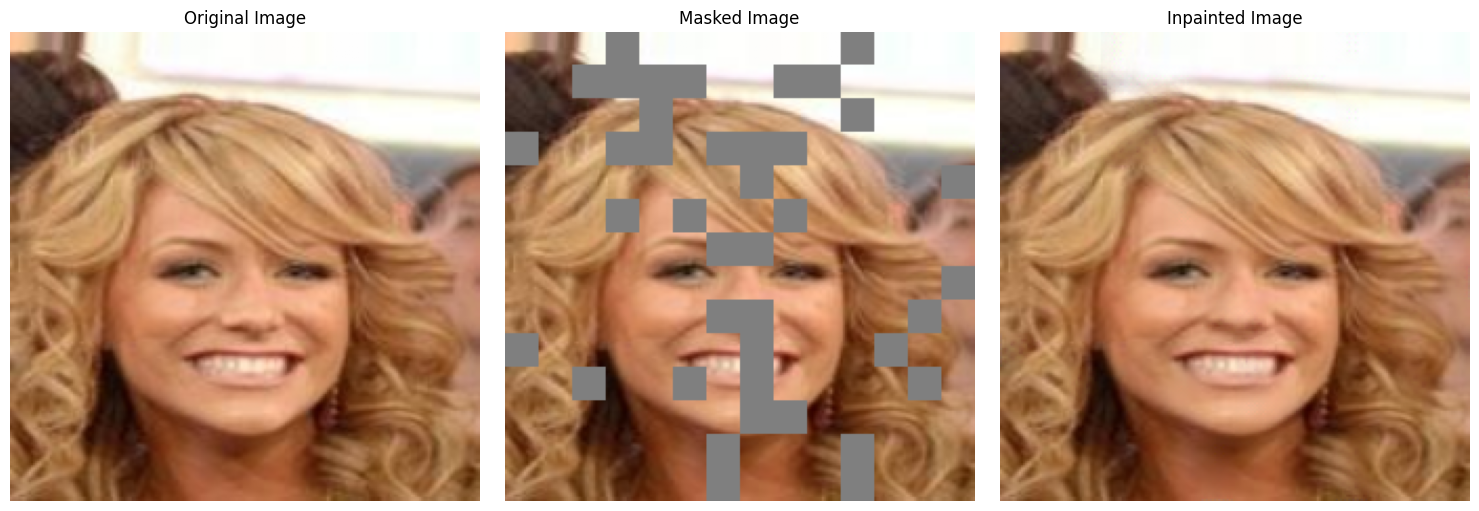

65


IndexError: index 64 is out of bounds for dimension 0 with size 64

In [18]:
model.load_state_dict(torch.load("best_model.pth")["model_state_dict"])
model.eval()

with torch.no_grad():
    for idx, (images, masked_images, masks) in enumerate(train_loader):
        images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)
        expanded_mask = masks.view(masks.size(0),14, 14)
        expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
        expanded_mask = expanded_mask.unsqueeze(1).float()
        outputs = model(masked_images, masks)
        print(idx)
        plot_sample_image(images[idx - 1], masked_images[idx - 1], outputs[idx - 1], expanded_mask[idx - 1])

## Evaluate

Saved: Transformer\Test Images\Image_573.png


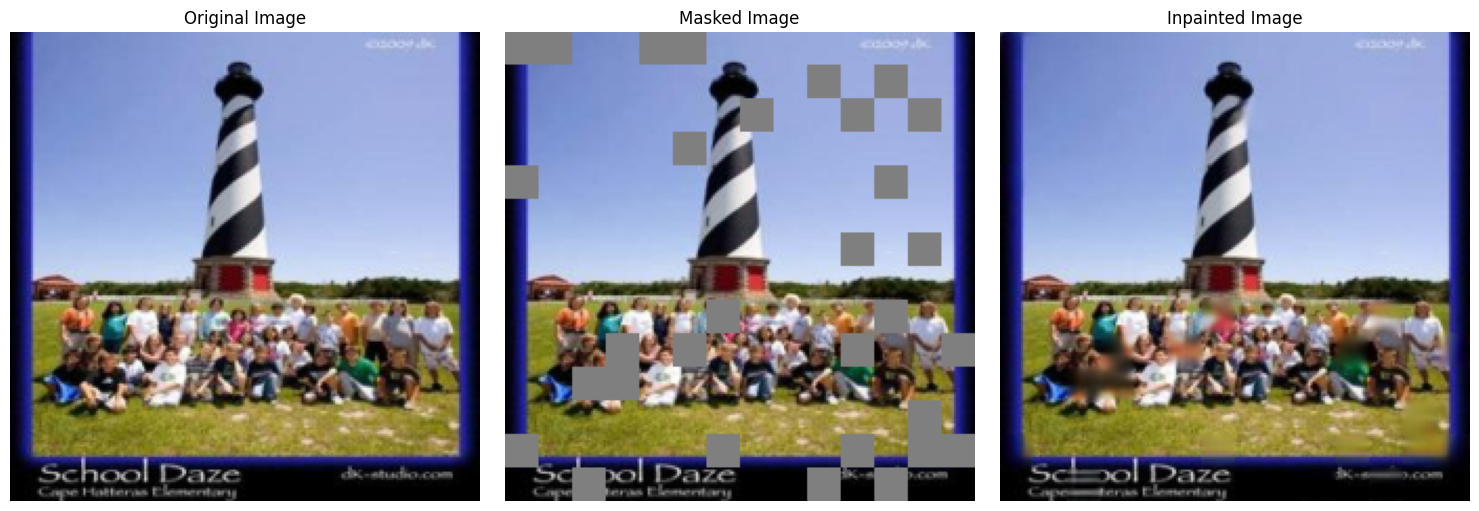

{'test_loss': 8.150791547384607e-05,
 'test_PSNR': 24.854042834546192,
 'test_accuracy': 14.654399183572057}

In [14]:
def evaluate(model, dataloader, criterion, device= "cuda", sample_size=5):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_PSNR = 0.0
    random_indices = random.sample(range(len(dataloader)), sample_size)

    with torch.no_grad():
        for idx, (images, masked_images, masks) in enumerate(dataloader):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            expanded_mask = masks.view(masks.size(0),14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()

            outputs = model(masked_images, masks)
            loss = 1 - criterion(outputs * expanded_mask, images * expanded_mask) 
            
            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_accuracy = pixel_accuracy(outputs, images, expanded_mask)
            
            if idx in random_indices:
                plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0],
                                  "Transformer\Test Images", f"Image_{idx}.png")
                
            test_loss = loss.item()
            test_PSNR += batch_psnr
            test_accuracy += batch_accuracy

        avg_test_loss = test_loss / len(valid_loader)
        avg_test_PSNR = test_PSNR / len(valid_loader)
        avg_test_accuracy = test_accuracy / len(valid_loader)

    return {"test_loss": avg_test_loss, "test_PSNR": avg_test_PSNR, "test_accuracy": avg_test_accuracy}


criterion = SSIM(data_range=1, size_average=True, channel=3)

evaluate(model, test_loader, criterion, device=device, sample_size=5)

## Loss Curves

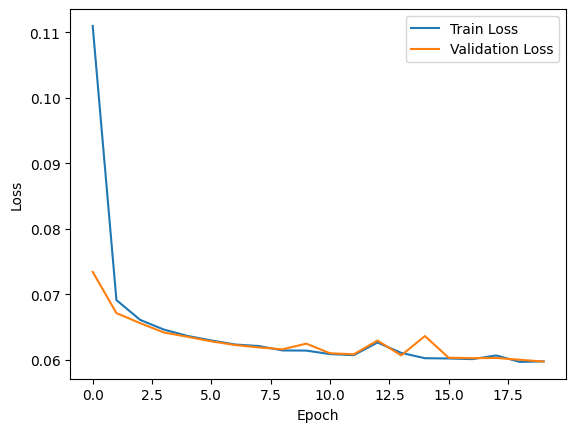

In [15]:
def plot_losses(losses):
    train_loss = losses["train_loss"]
    val_loss = losses["val_loss"]

    plt.figure()
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses)